In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import spacy
import sklearn as sk
import re
# For handling string
import string
# For performing mathematical operations
import math
# extract date 
#import datefinder
#matches = datefinder.find_dates(string_with_dates)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pyLDAvis.sklearn

In [3]:
amazon_reviews = pd.read_csv("C:\\Users\\DELL\\allreviews_samsung.csv")
'''
amazon_reviews.head()
amazon_reviews.shape
amazon_reviews.info
amazon_reviews.dtypes
amazon_reviews.isnull().sum()

amazon_reviews['review_date'].head
'''

"\namazon_reviews.head()\namazon_reviews.shape\namazon_reviews.info\namazon_reviews.dtypes\namazon_reviews.isnull().sum()\n\namazon_reviews['review_date'].head\n"

In [4]:
# storing only customer reviews data
data=amazon_reviews[['review_date','comment', 'stars']]
data.describe()   
data.head()

# Data Cleaning and Preprocessing
data = data.replace('\n',' ', regex=True)
data = data.rename(columns ={"comment": "review_content"})                             
#data = data.drop(['url'],axis = 1)
data.describe()   


,stars
count,5000.000000
mean,4.347400
std,1.174133
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [5]:
data['review_content'] = data['review_content'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]+',' ', x))
data['review_content'] = data['review_content'].apply(lambda x: re.sub(r'[^\w\s]','', x))
data['review_content'] = data['review_content'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z\t])|\
                                                                                (\w+:\/\/\S+)", " ", x).split()))
data['review_content'] = data['review_content'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['review_content'].head()

<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-5-a7a5b657d102>:4: DeprecationWarning: invalid escape sequence \w
  (\w+:\/\/\S+)", " ", x).split()))


0    i bought this128 gb samsung memory card in apr...
1    reviewing after more than a year storage for p...
2    things i liked about this product1 it has a 32...
3    i purchased this 128gb samsung sd card and the...
4    the card wrote at 45 55mb s thru the adapter a...
Name: review_content, dtype: object

In [6]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not", "adaptor": "adapter",                      "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not", "<": "less than",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would", "price'": "price",
                     "product'": "product", "good'": "good",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}


In [7]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
data['review_content']=data['review_content'].apply(lambda x:expand_contractions(x))
data['review_content'].head

<bound method NDFrame.head of 0       i bought this128 gb samsung memory card in apr...
1       reviewing after more than a year storage for p...
2       things i liked about this product1 it has a 32...
3       i purchased this 128gb samsung sd card and the...
4       the card wrote at 45 55mb s thru the adapter a...
                              ...                        
4995            good product right price good performance
4996    good card for my samsung s8 w r speed is very ...
4997                                    very nice product
4998                                                 good
4999                                               superb
Name: review_content, Length: 5000, dtype: object>

In [8]:
# Remove digits and words containing digits
data['review_content']=data['review_content'].apply(lambda x: re.sub('\w*\d\w*','', x))
# Removing extra spaces
data['review_content']=data['review_content'].apply(lambda x: re.sub(' +',' ', x))

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-8-91da47d54efe>:2: DeprecationWarning: invalid escape sequence \w
  data['review_content']=data['review_content'].apply(lambda x: re.sub('\w*\d\w*','', x))


In [9]:
data.isnull().sum()

review_date       0
review_content    0
stars             0
dtype: int64

In [10]:
#Remove Punctuations and single words
data['review_content']=data['review_content'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
data['review_content']=data['review_content'].apply(lambda x: re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', x))
 

In [11]:
nlp = spacy.load("en_core_web_sm")


In [12]:
# Lemmatization with stopwords removal
data['lemmatized']=data['review_content'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
data['lemmatized'].head

<bound method NDFrame.head of 0       buy gb samsung memory card april thinking low ...
1       review year storage price build resistance won...
2       thing like gb storage class sd value easy inst...
3       purchase samsung sd card storage capacity chip...
4       card write adapter read great value money good...
                              ...                        
4995            good product right price good performance
4996                 good card samsung speed good satisfy
4997                                         nice product
4998                                                 good
4999                                               superb
Name: lemmatized, Length: 5000, dtype: object>

In [13]:
data['tokenized'] = data['lemmatized'].apply(lambda x: nlp.tokenizer(x))
data['tokenized'].head

<bound method NDFrame.head of 0       (buy, gb, samsung, memory, card, april, thinki...
1       (review, year, storage, price, build, resistan...
2       (thing, like, gb, storage, class, sd, value, e...
3       (purchase, samsung, sd, card, storage, capacit...
4       (card, write, adapter, read, great, value, mon...
                              ...                        
4995     (good, product, right, price, good, performance)
4996          (good, card, samsung, speed, good, satisfy)
4997                                      (nice, product)
4998                                               (good)
4999                                             (superb)
Name: tokenized, Length: 5000, dtype: object>

In [14]:
from textblob import TextBlob

polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

data['POLARITY'] = data['lemmatized'].apply(polarity)
data['SUBJECTIVITY'] = data['lemmatized'].apply(subjectivity)
data.head()
data.describe()
data.columns

C:\Users\DELL\anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\DELL\anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\Users\DELL\anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


Index(['review_date', 'review_content', 'stars', 'lemmatized', 'tokenized',
       'POLARITY', 'SUBJECTIVITY'],
      dtype='object')

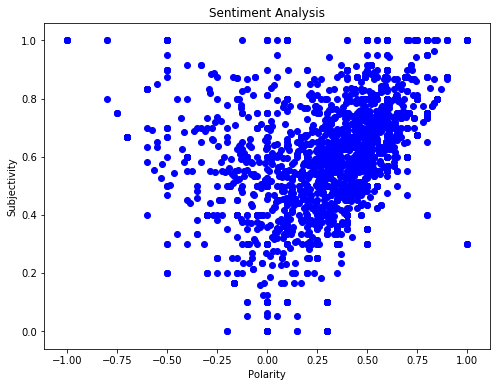

In [15]:
# Plotting polarity vs subjectivity
plt.figure(figsize=(8,6)) 

for i in range(0, data.shape[0]):
  plt.scatter(data['POLARITY'][i], data['SUBJECTIVITY'][i], color='Blue') 
# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [18]:
#define sentiment class
# decide sentiment as positive, negative and neutral 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sen_obj = SentimentIntensityAnalyzer() 
data['scores'] = data['lemmatized'].apply(lambda lemmatized: sen_obj.polarity_scores(lemmatized))
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data['neu_score']  = data['scores'].apply(lambda score_dict: score_dict['neu'])
data['pos_score']  = data['scores'].apply(lambda score_dict: score_dict['pos'])
data['neg_score']  = data['scores'].apply(lambda score_dict: score_dict['neg'])

data.head()


,review_date,review_content,stars,lemmatized,tokenized,POLARITY,SUBJECTIVITY,scores,compound,neu_score,pos_score,neg_score
0,04-Dec-18,bought gb samsung memory card in april thinkin...,2.0,buy gb samsung memory card april thinking low ...,"(buy, gb, samsung, memory, card, april, thinki...",-0.416667,0.683333,"{'neg': 0.263, 'neu': 0.737, 'pos': 0.0, 'comp...",-0.8402,0.737,0.000,0.263
1,11-Dec-17,reviewing after more than year storage for pri...,5.0,review year storage price build resistance won...,"(review, year, storage, price, build, resistan...",1.000000,1.000000,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...",0.7003,0.580,0.420,0.000
2,21-May-19,things liked about this it has gb of storage i...,5.0,thing like gb storage class sd value easy inst...,"(thing, like, gb, storage, class, sd, value, e...",0.433333,0.833333,"{'neg': 0.0, 'neu': 0.597, 'pos': 0.403, 'comp...",0.8957,0.597,0.403,0.000
3,30-Dec-18,purchased this samsung sd card and the storage...,1.0,purchase samsung sd card storage capacity chip...,"(purchase, samsung, sd, card, storage, capacit...",-0.487500,0.504167,"{'neg': 0.227, 'neu': 0.659, 'pos': 0.115, 'co...",-0.7650,0.659,0.115,0.227
4,07-Jun-19,the card wrote at thru the adapter and read at...,4.0,card write adapter read great value money good...,"(card, write, adapter, read, great, value, mon...",0.750000,0.675000,"{'neg': 0.0, 'neu': 0.561, 'pos': 0.439, 'comp...",0.8555,0.561,0.439,0.000


In [19]:
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    if(score['compound']>=0.2):
        return 'pos'
    elif(score['compound']<=-0.2):
        return 'neg'
    else:
        return 'neu'
  

data['sentiment'] = data['lemmatized'].apply(lambda x: sentiment_analyzer_scores(x))   

data.sentiment.value_counts()

pos    3838
neu     840
neg     322
Name: sentiment, dtype: int64

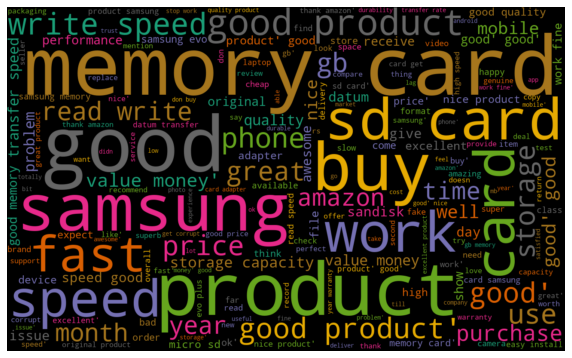

In [20]:
def generate_wordcloud(data):
  wc = WordCloud(width=1299, height=800, max_words=200,random_state=1234,colormap="Dark2").generate(str(data))
  #PLOT
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  
Word_data=data['tokenized'].astype('str').tolist()
generate_wordcloud(Word_data)


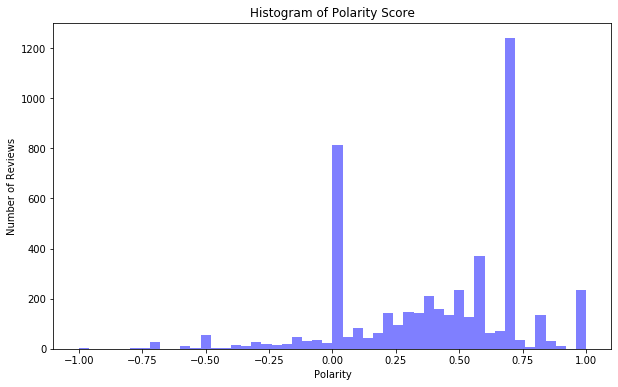

In [21]:
# Histogram of polarity score
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(data.POLARITY, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show()

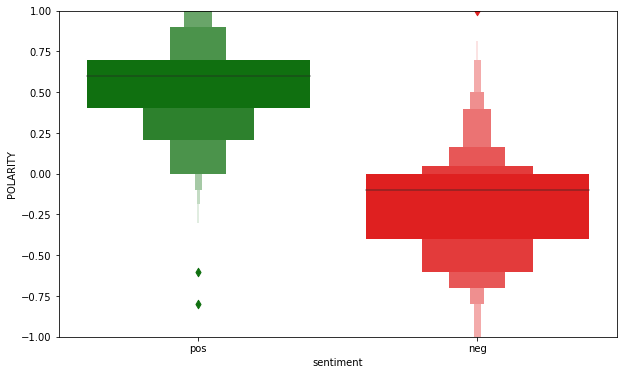

In [22]:
# polarity vs sentiment
plt.figure(figsize=(10,6))
colors = ["green", "red"]
xy = data.groupby('sentiment')
data['sentiment'].value_counts()
df_xy = xy.get_group('pos') 
df_xy1 = xy.get_group('neg') 
df_xy1.shape
df_xy.shape
df_xy = df_xy.append(df_xy1)
sns.boxenplot(x='sentiment', y='POLARITY', data=df_xy, palette = colors).set(ylim=(-1,1))
plt.show();

Text(0.5, 1.0, 'Distribution of Subjectivity Score')

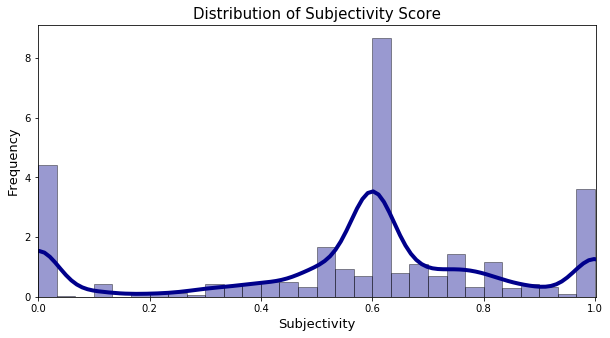

In [23]:
# Density Plot and Histogram of subjectivity
plt.figure(figsize=(10,5))
sns.distplot(data['SUBJECTIVITY'], hist=True, kde=True,
bins=int(30), color = 'darkblue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity Score', fontsize=15)


Text(0.5, 1.0, 'Sentiment Analysis')

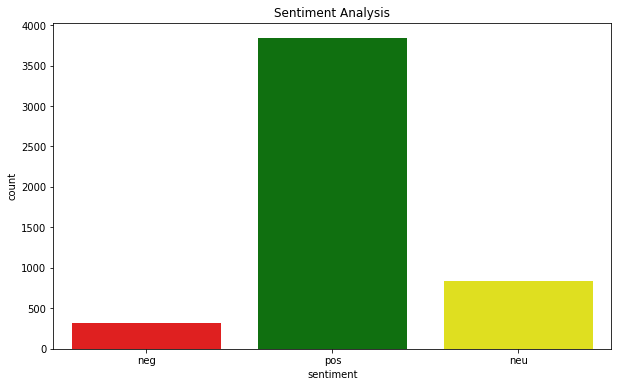

In [24]:
#sentiment analysis plot
plt.rcParams['figure.figsize'] = (10.0, 6.0)
#plt.rcParams['font.family'] = "serif"
colors = ["red", "green", "yellow"]
p = sns.countplot(data=data, x = 'sentiment', palette = colors)
plt.title('Sentiment Analysis')


<Figure size 2160x720 with 0 Axes>

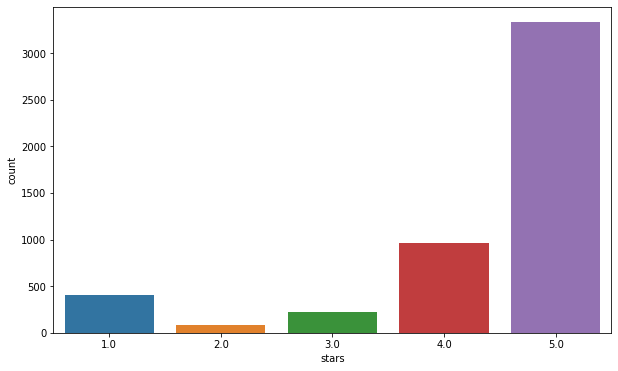

<Figure size 2160x720 with 0 Axes>

In [25]:
# bar chart for review ratings
p = sns.countplot(data=amazon_reviews , x = 'stars')
plt.figure(figsize=(30,10))


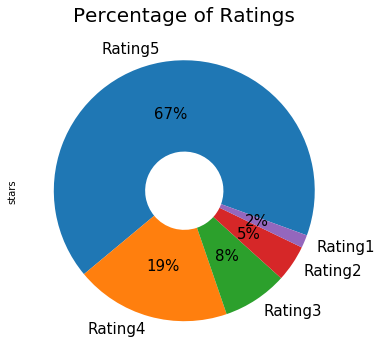

In [26]:
plt.title('Percentage of Ratings', fontsize=20)
amazon_reviews.stars.value_counts().plot(kind='pie', labels=['Rating5', 'Rating4', 'Rating3', 'Rating2', 'Rating1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})


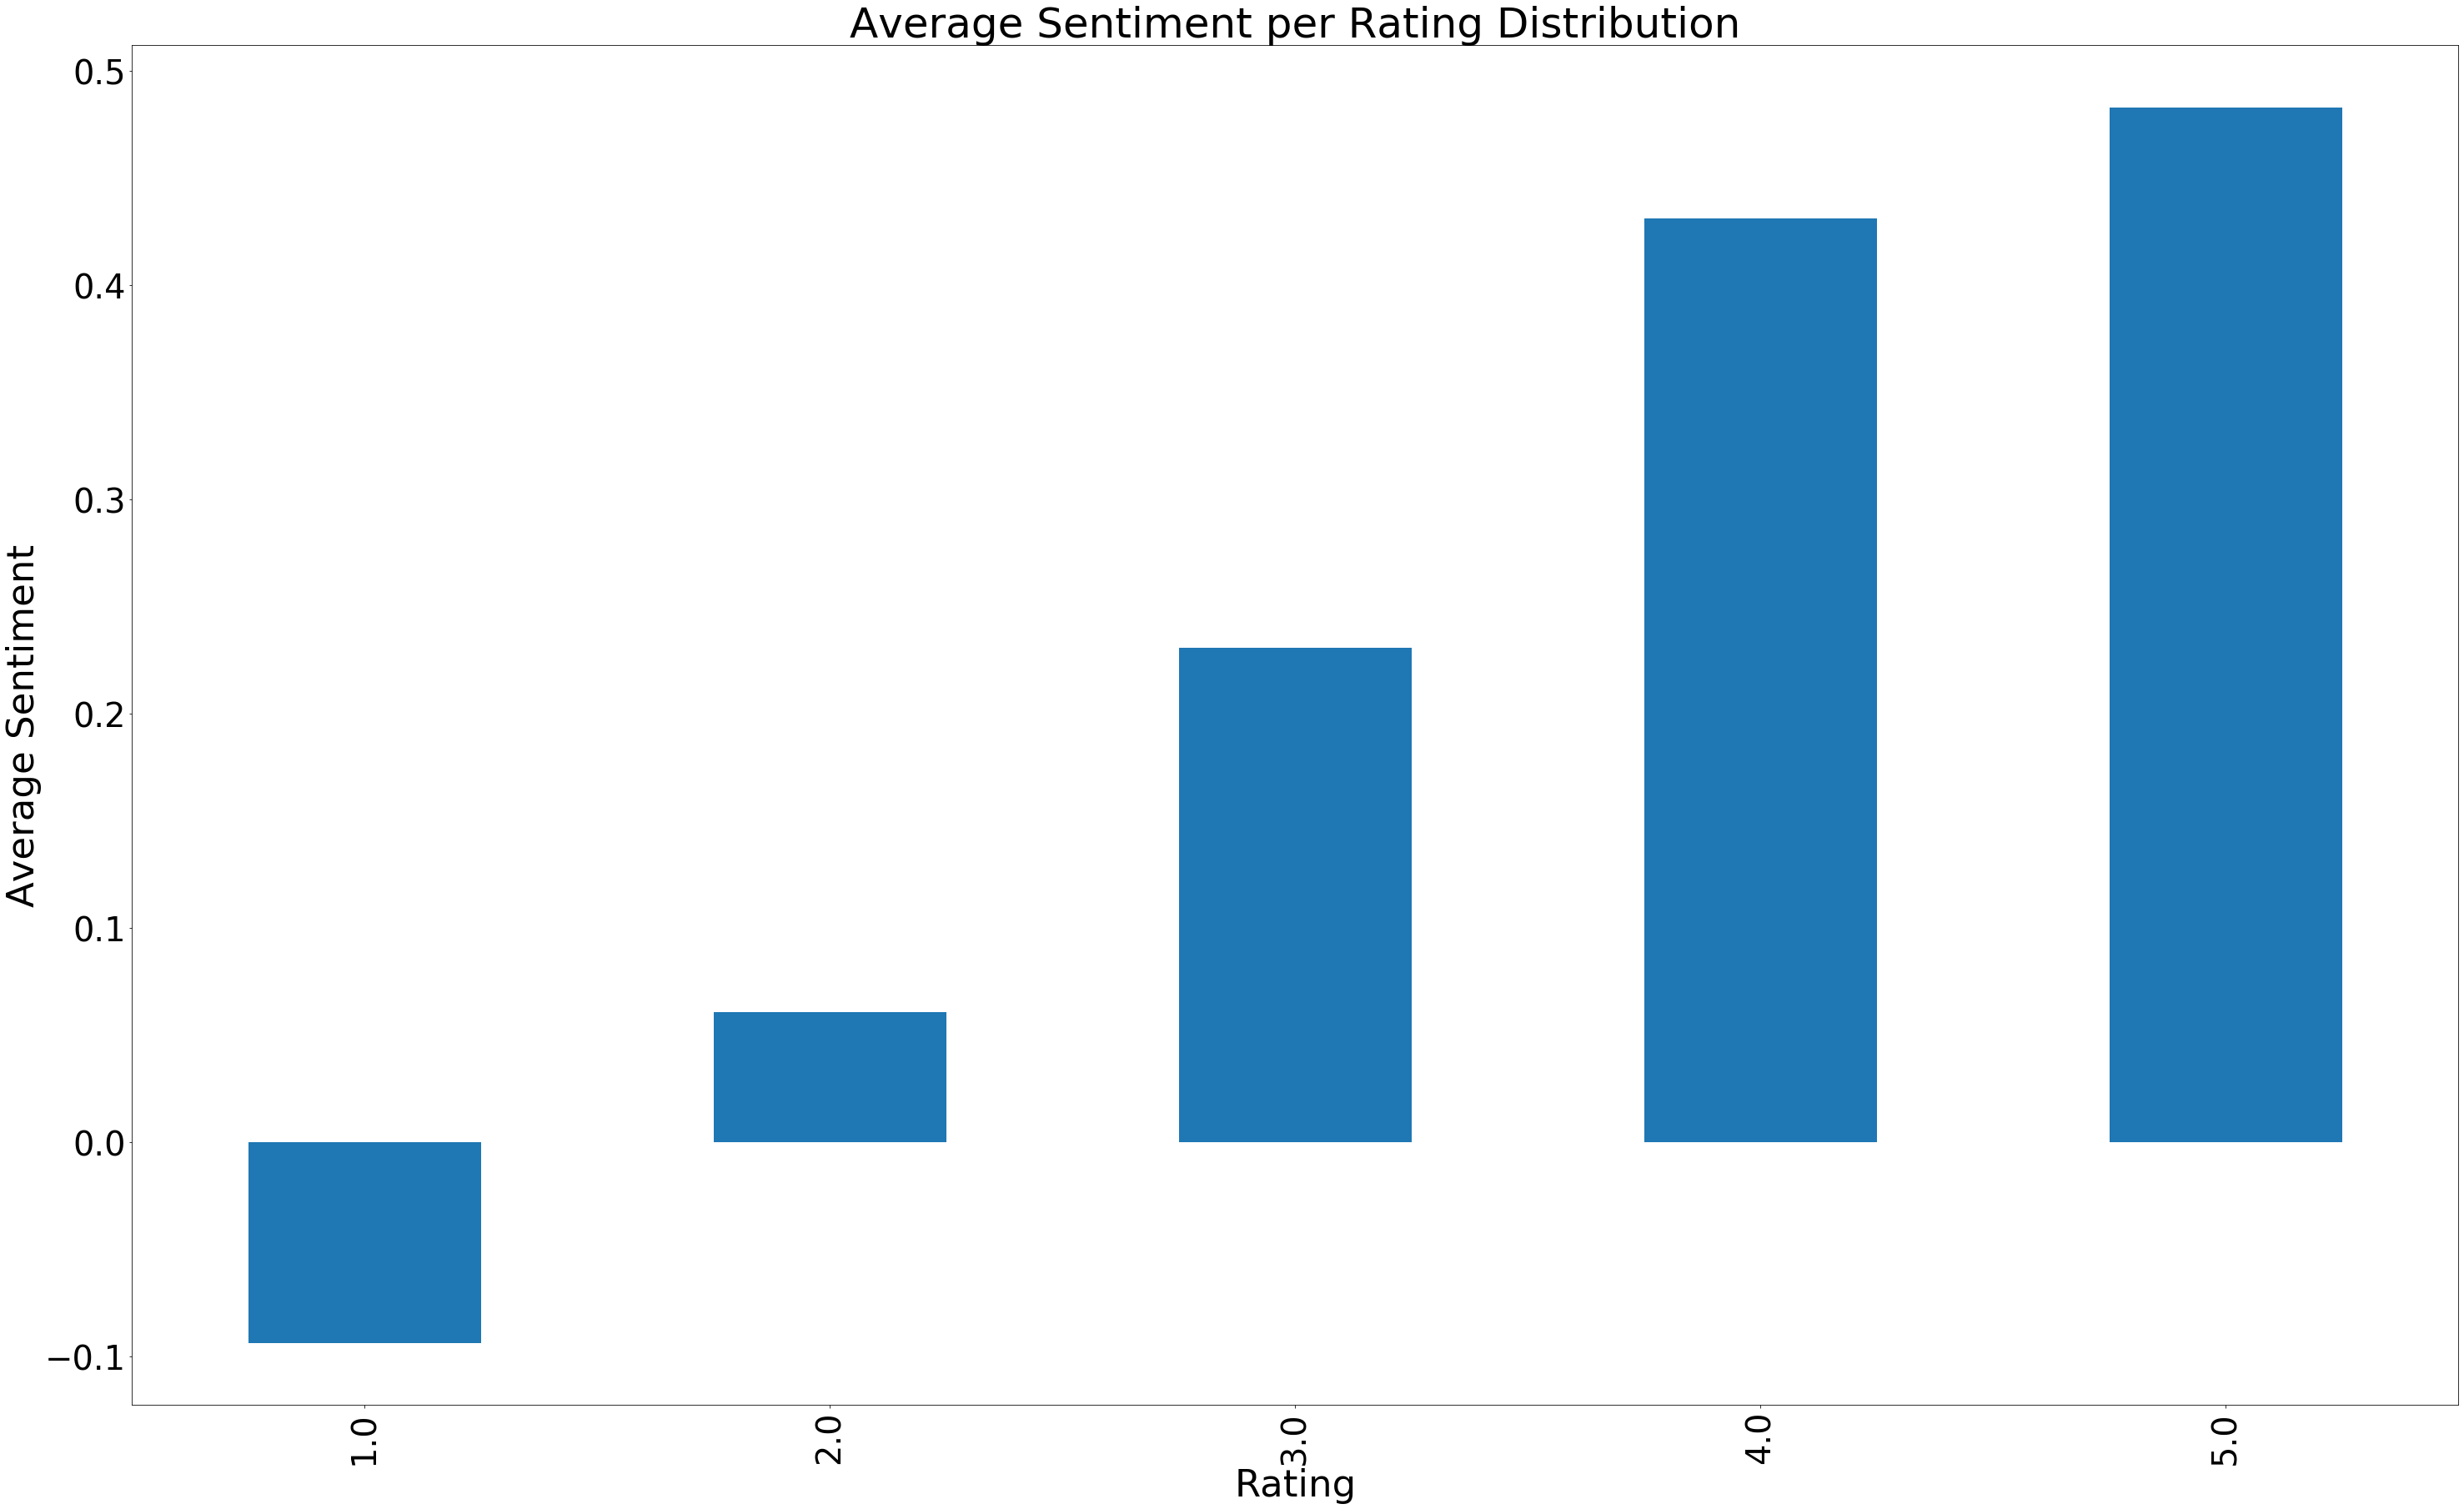

In [27]:
polarity_avg = data.groupby('stars')['POLARITY'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()


ValueError: too many values to unpack (expected 2)

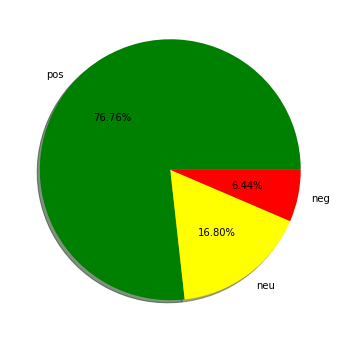

In [28]:
#pie chart for sentiment
labels = ['pos', 'neu', 'neg']
colors = ['green', 'yellow', 'red']
patches, texts = plt.pie(data['sentiment'].value_counts(), colors=colors, shadow=True, labels = labels,autopct='%1.2f%%')
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
# applying groupby() function to 
group_bysentiment = data.groupby('sentiment') 
data['sentiment'].value_counts()
pos_review = group_bysentiment.get_group('pos') 
neu_review = group_bysentiment.get_group('neu') 
neg_review = group_bysentiment.get_group('neg') 

pos_data = pos_review['tokenized'].astype('str').tolist()
generate_wordcloud(pos_data)


In [ ]:
neu_data = neu_review['tokenized'].astype('str').tolist()
generate_wordcloud(neu_data)

neg_data = neg_review['tokenized'].astype('str').tolist()
generate_wordcloud(neg_data)



In [ ]:
# ratings
gk = data.groupby('stars') 
data['stars'].value_counts()


In [ ]:
# unigrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['lemmatized'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
sns.barplot(data = df2
            ,x = 'count'
            ,y = 'unigram'
            ,color = 'cyan' 
            ,ci = None
            )
plt.title('Top 30 unigrams of reviews')


In [ ]:
## bigrams
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data['lemmatized'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

sns.barplot(data = df3
            ,x = 'count'
            ,y = 'bigram'
            ,color = 'cyan' 
            ,ci = None
            )
plt.title('Top 20 bigrams of reviews')


In [ ]:
## trigrams
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(data['lemmatized'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

sns.barplot(data = df4
            ,x = 'count'
            ,y = 'trigram'
            ,color = 'cyan' 
            ,ci = None
            )
plt.title('Top 20 trigrams of reviews')



In [ ]:
#TOP MODELLING
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(data['lemmatized'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 25

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] 
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)


In [51]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  28.758874
2       51.163364 -159.968018       2        1  20.653969
3      -73.144554   21.523815       3        1  20.377311
1      -66.410133 -110.606438       4        1  19.564383
0       54.417324   12.443444       5        1  10.645463, topic_info=          Term         Freq        Total Category  logprob  loglift
70        good  2140.000000  2140.000000  Default  30.0000  30.0000
157      speed  1044.000000  1044.000000  Default  29.0000  29.0000
123    product  1462.000000  1462.000000  Default  28.0000  28.0000
188       work   712.000000   712.000000  Default  27.0000  27.0000
99       money   347.000000   347.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
79       issue    28.189037   138.557105   Topic5  -4.6055   0.6477
112  packaging     6.775028    38.591347   Topic5  -6.0312   0.5003
14         buy    73.840468   499.976672   Topic5  -3.6425   0.3274
193       year    23.428769   204.033675   Topic5  -4.7905   0.0757
67         get    10.863244   318.710422   Topic5  -5.5591  -1.1389

[220 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         5  0.986585   action
2         1  0.410835  adapter
2         2  0.252370  adapter
2         5  0.334537  adapter
3         2  0.988013  amazing
...     ...       ...      ...
191       2  0.997203    write
192       2  0.989067  writing
193       1  0.127430     year
193       4  0.754777     year
193       5  0.112726     year

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

In [52]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf


,able,action,adapter,amazing,amazon,android,app,available,average,awesome,...,warranty,waste,water,well,work,working,worth,write,writing,year
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.376868,0.0,0.0,0.0,0.000000,0.0,0.366129
2,0.0,0.0,0.187663,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.369962,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.0,0.0,0.279563,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.232134,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4996,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4997,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
4998,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


In [53]:
nmf = NMF(n_components=5, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
good quality speed price performance storage transfer capacity use far working read easy delivery till product item rate overall write packaging install pretty durability build
Topic 1:
product excellent original great amazon samsung price quality delivery awesome genuine buy like happy thank service deliver get love amazing bad fast superb recommend problem
Topic 2:
card memory speed work samsung sd buy gb write fast read storage transfer get phone price great use quality year amazon month fine datum like
Topic 3:
nice speed price transfer easy quality storage working rate super range fast datum use check product read install amazon satisfied useful deal thank build long
Topic 4:
money value excellent worth great storage capacity easy install price buy perfect performance waste well expect purchase overall useful fast durable use year video durability


In [54]:
nmf_topic_values = nmf.transform(tfidf)
data['nmf_topics'] = nmf_topic_values.argmax(axis=1)
lda_topic_values = lda_model.transform(tf)
data['lda_topics'] = lda_topic_values.argmax(axis=1)
lda_remap = {0: 'value for money', 1: 'Warranty issues', 2: 'Performance', 3: 'Quality', 4: 'Storage capacity'}
data['lda_topics'] = data['lda_topics'].map(lda_remap)
nmf_remap = {0: 'Performance', 1: 'Quality', 2: 'working rate', 3: 'speed', 4: 'value for money'}
data['nmf_topics'] = data['nmf_topics'].map(nmf_remap)

data.describe
data.dtypes


review_date        object
review_content     object
stars             float64
lemmatized         object
tokenized          object
POLARITY          float64
SUBJECTIVITY      float64
scores             object
compound          float64
neu_score         float64
pos_score         float64
neg_score         float64
sentiment          object
nmf_topics         object
lda_topics         object
dtype: object

In [55]:
data.to_csv(r'C:\\Users\\DELL\\Desktop\\data_cleaning_&_EDA__text.csv')

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]),
 <a list of 9 Text xticklabel objects>)

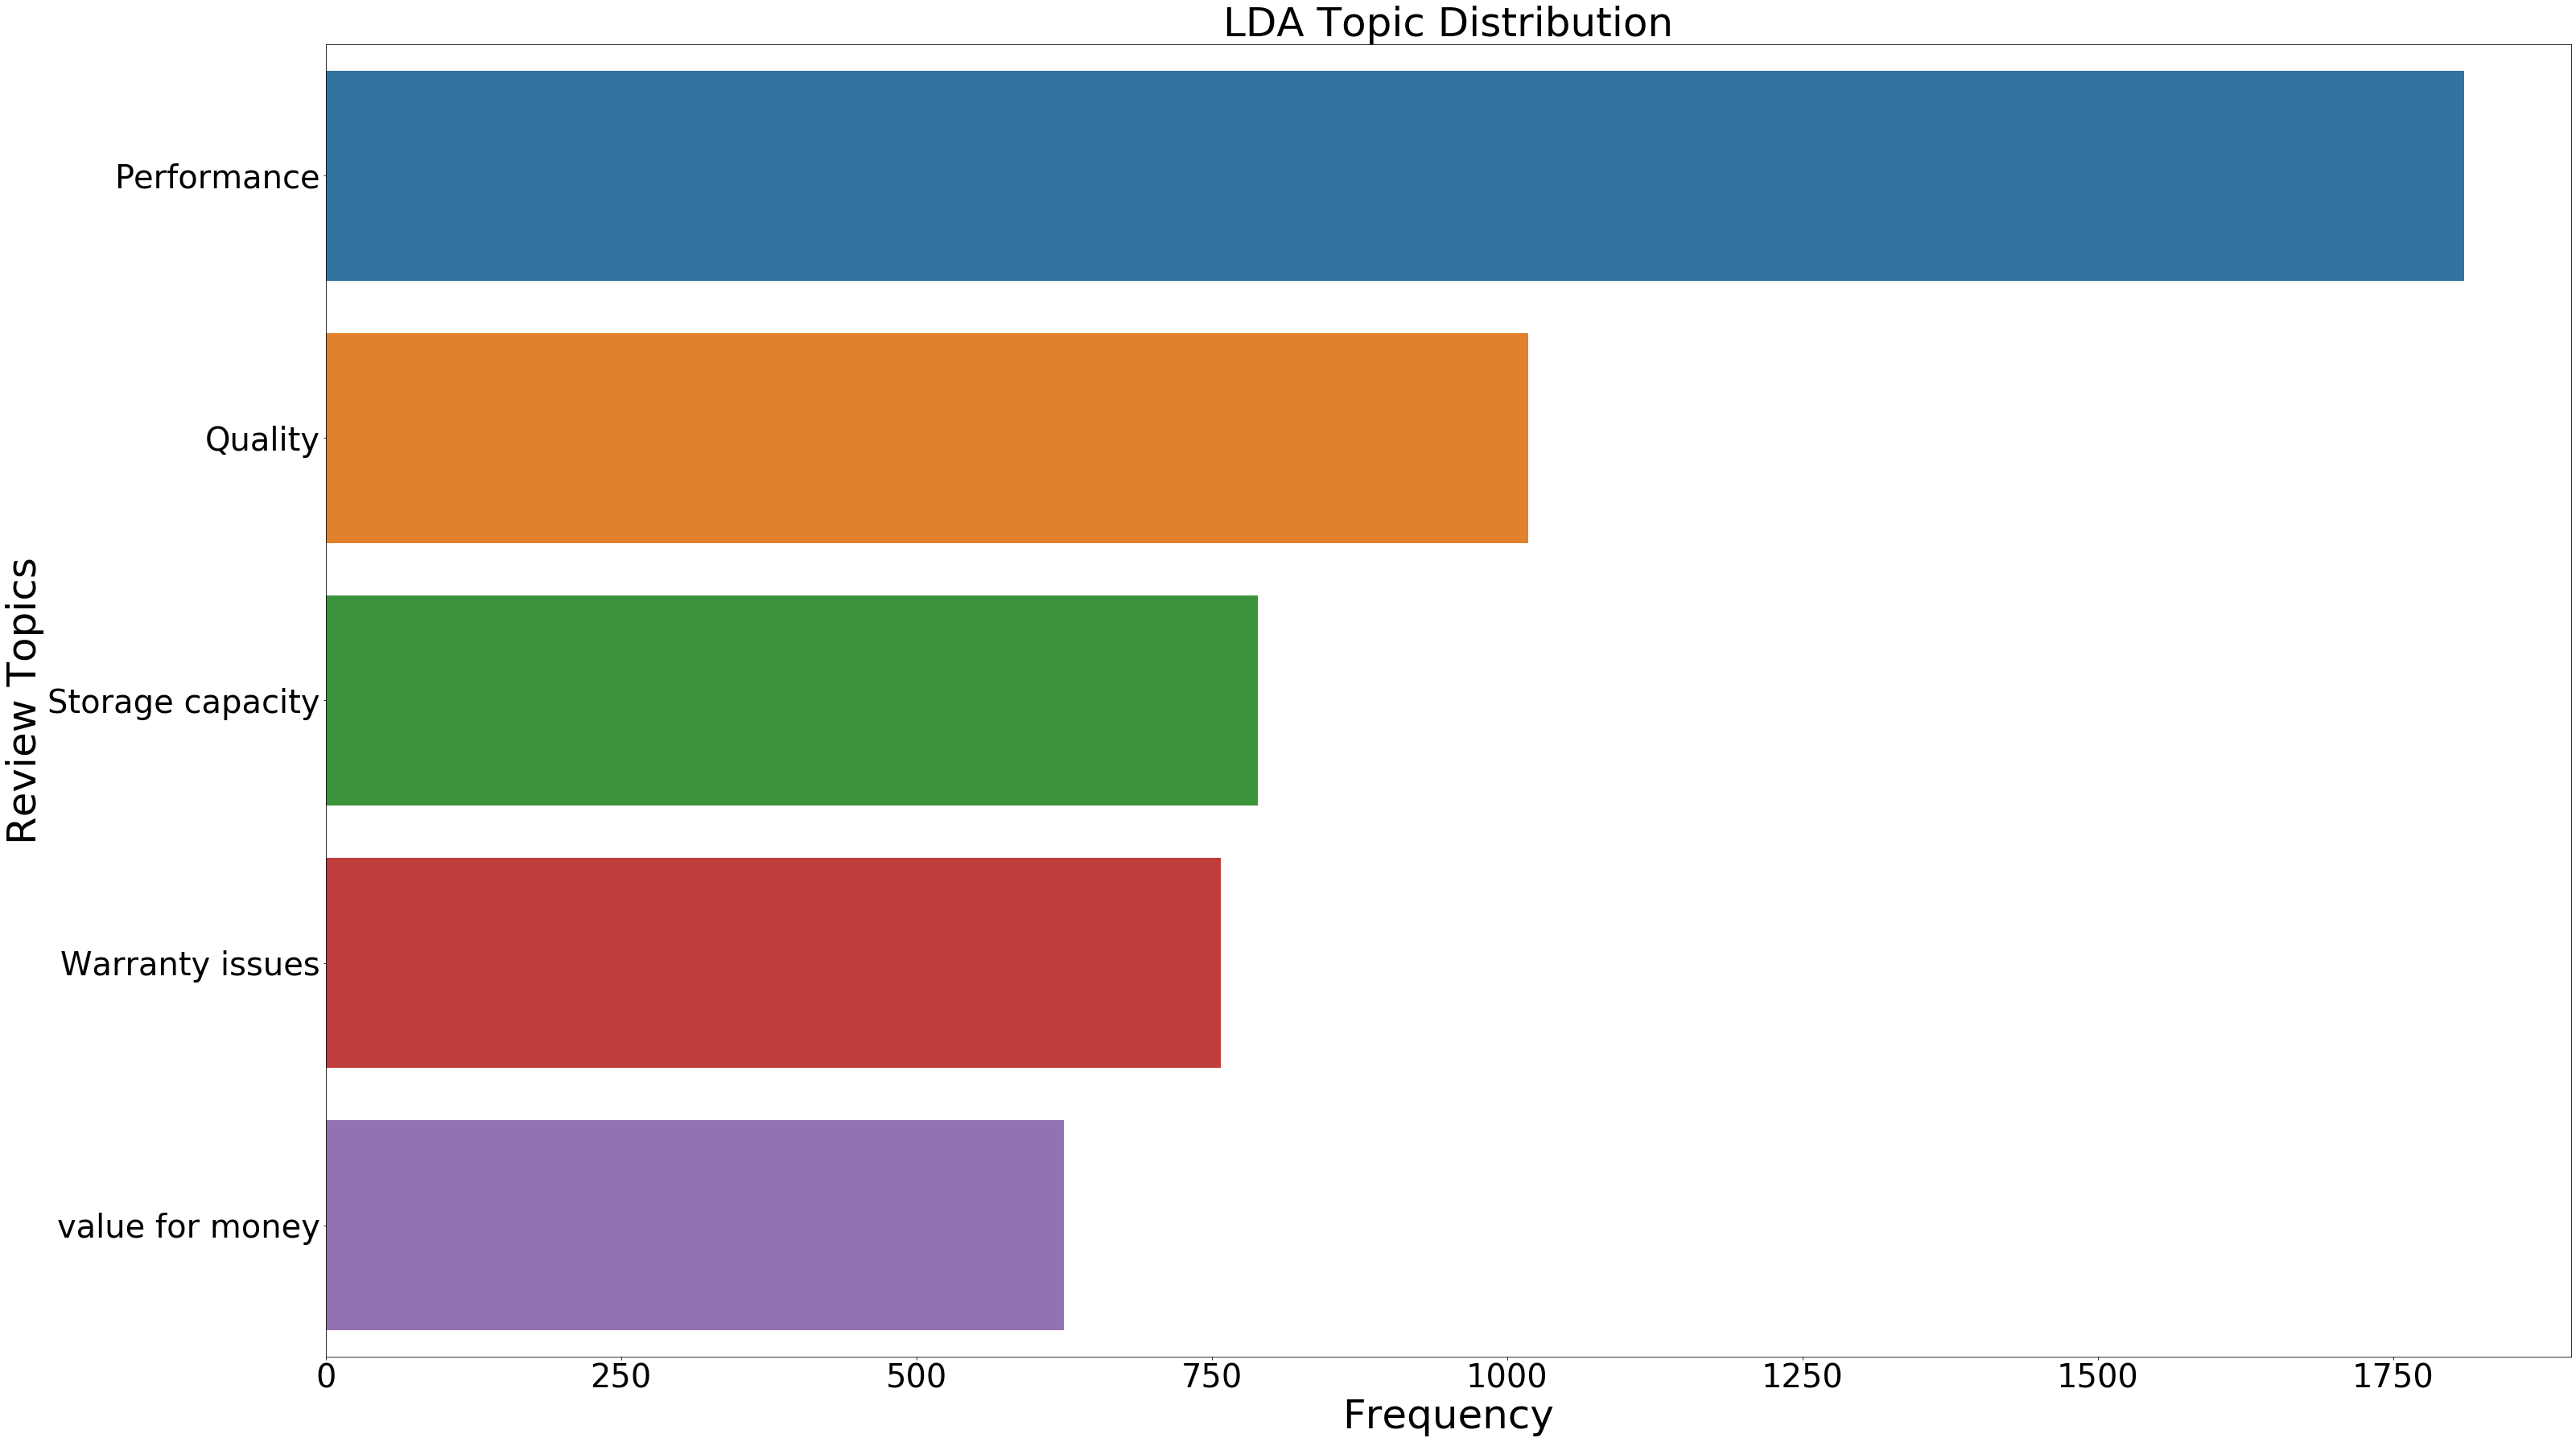

In [56]:
lda_x = data['lda_topics'].value_counts()
lda_y = lda_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(lda_x, lda_y.index)
plt.title("LDA Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]),
 <a list of 9 Text xticklabel objects>)

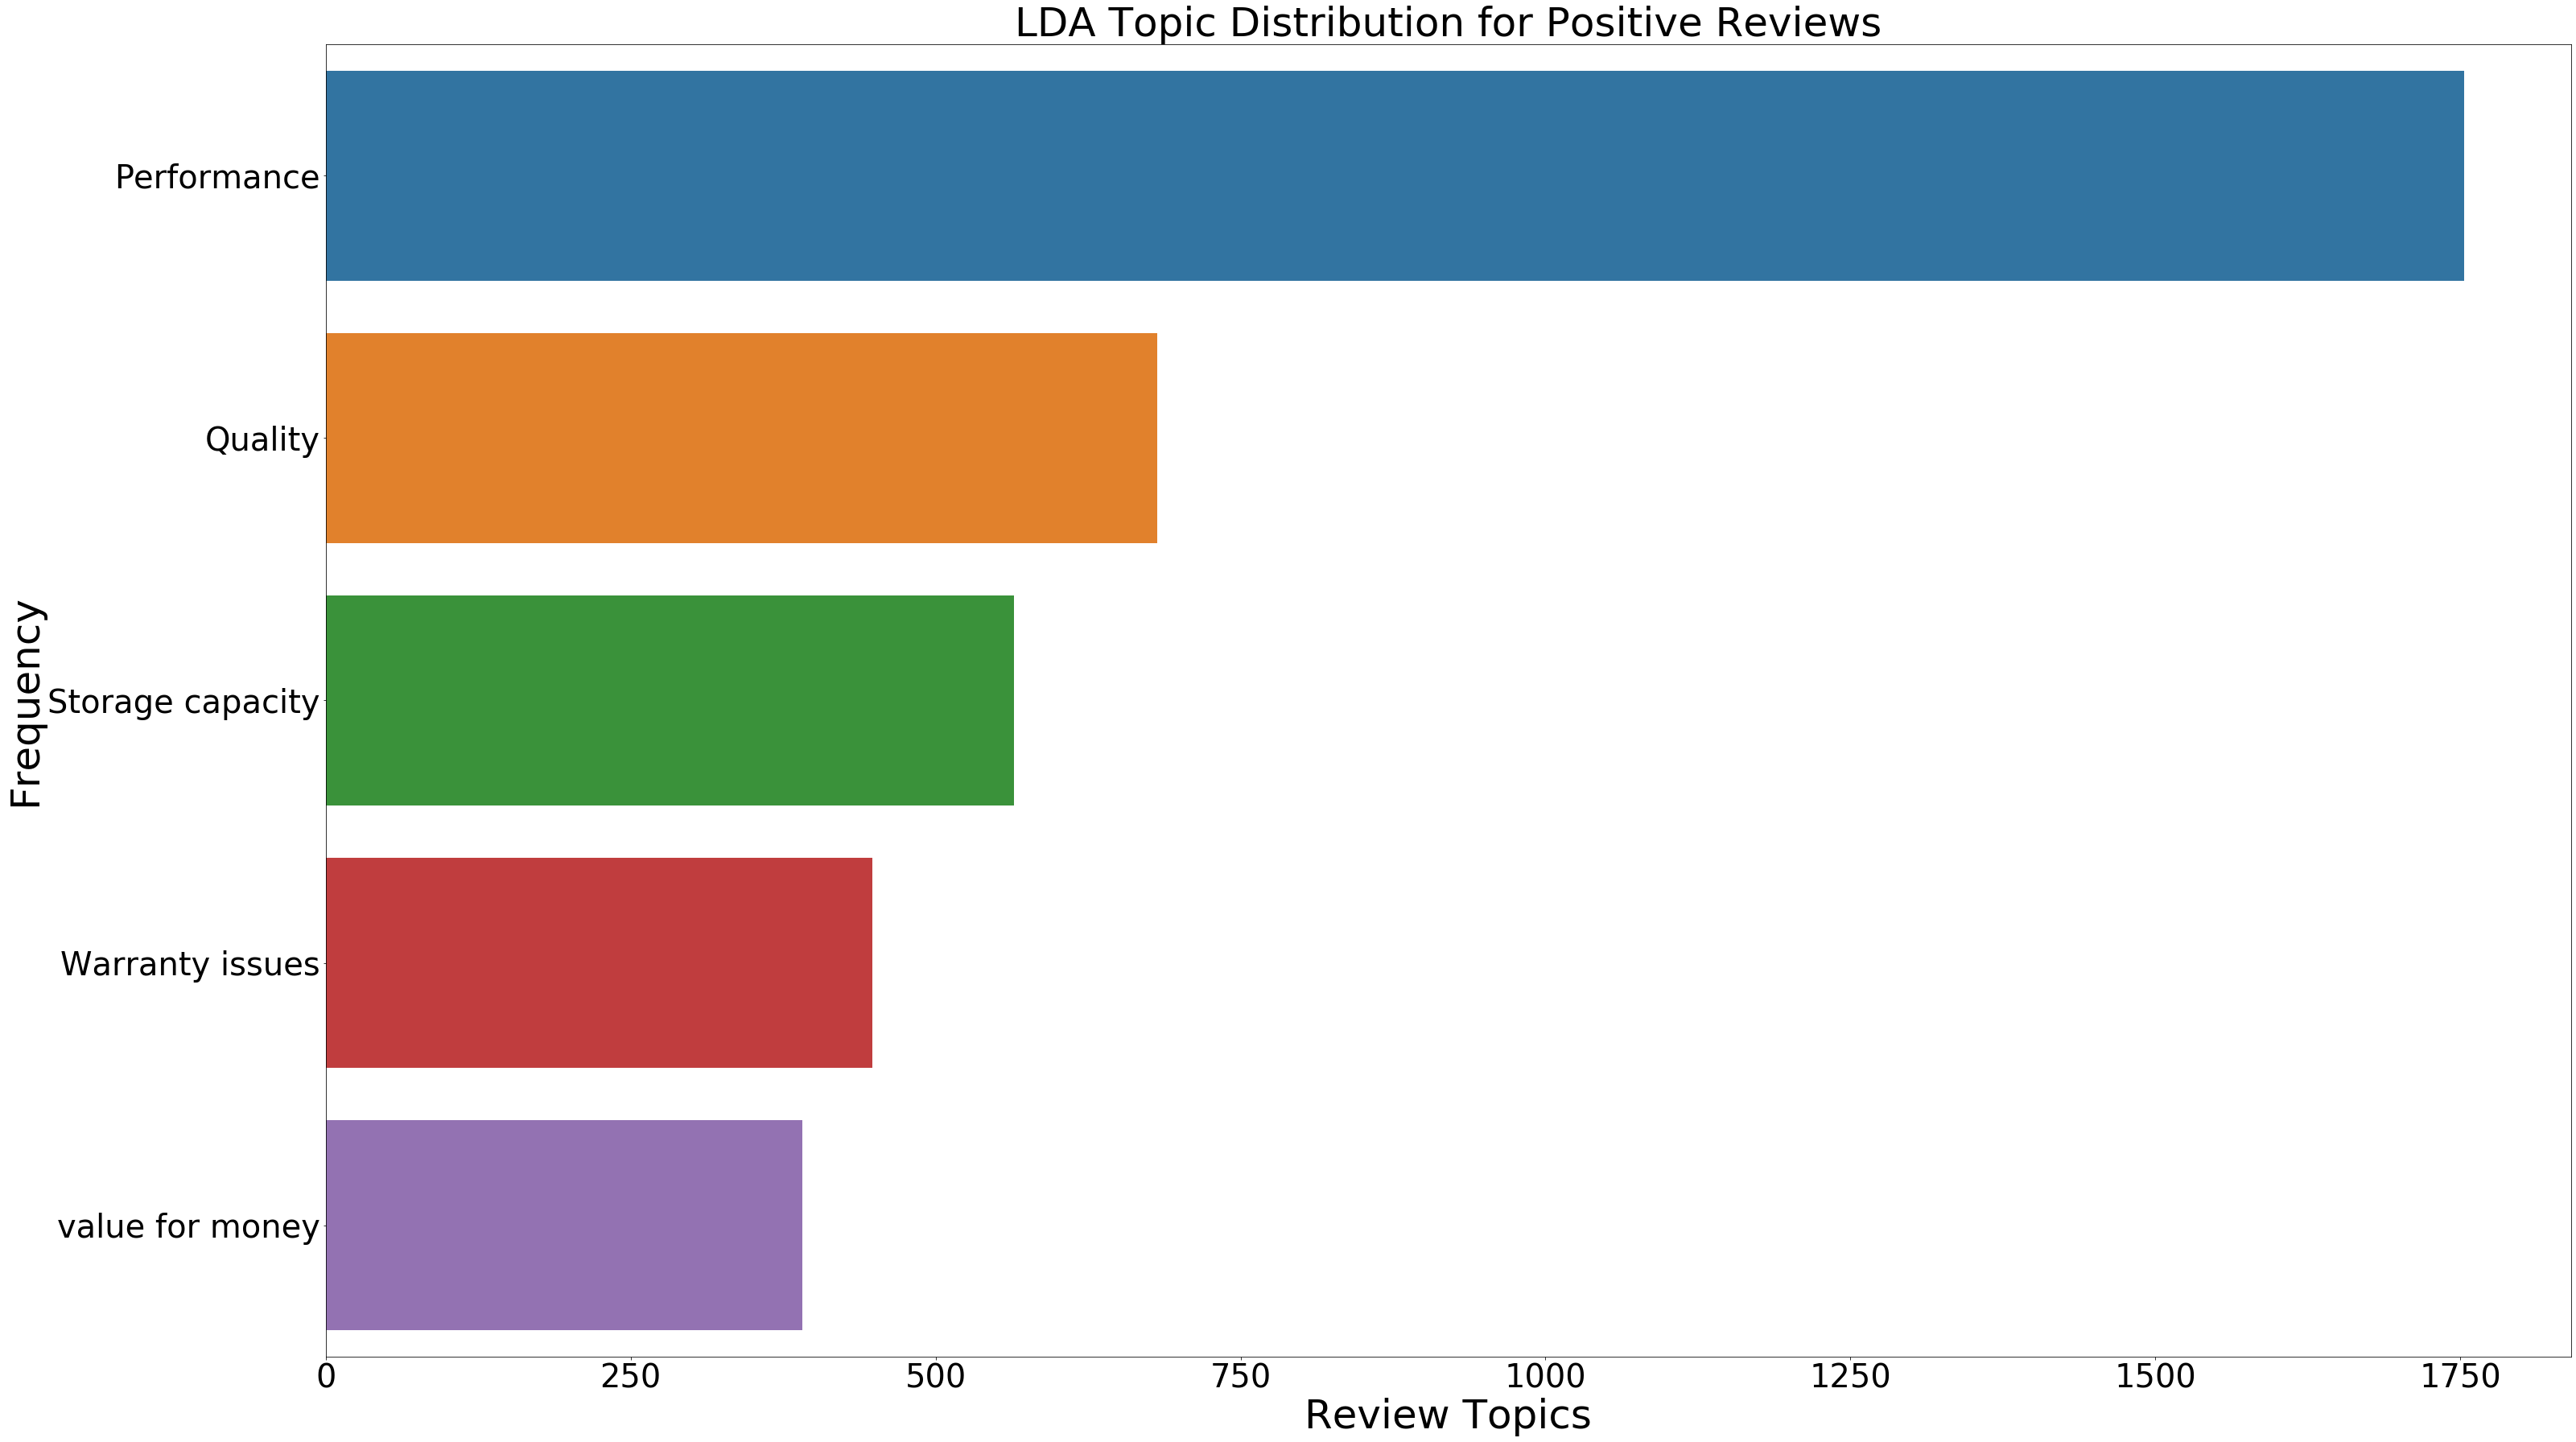

In [57]:
df_pos_ratings = data.loc[(data['sentiment']=='pos')]
lda_pos_x = df_pos_ratings['lda_topics'].value_counts()
lda_pos_y = lda_pos_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(lda_pos_x, lda_pos_y.index)
plt.title("LDA Topic Distribution for Positive Reviews", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 9 Text xticklabel objects>)

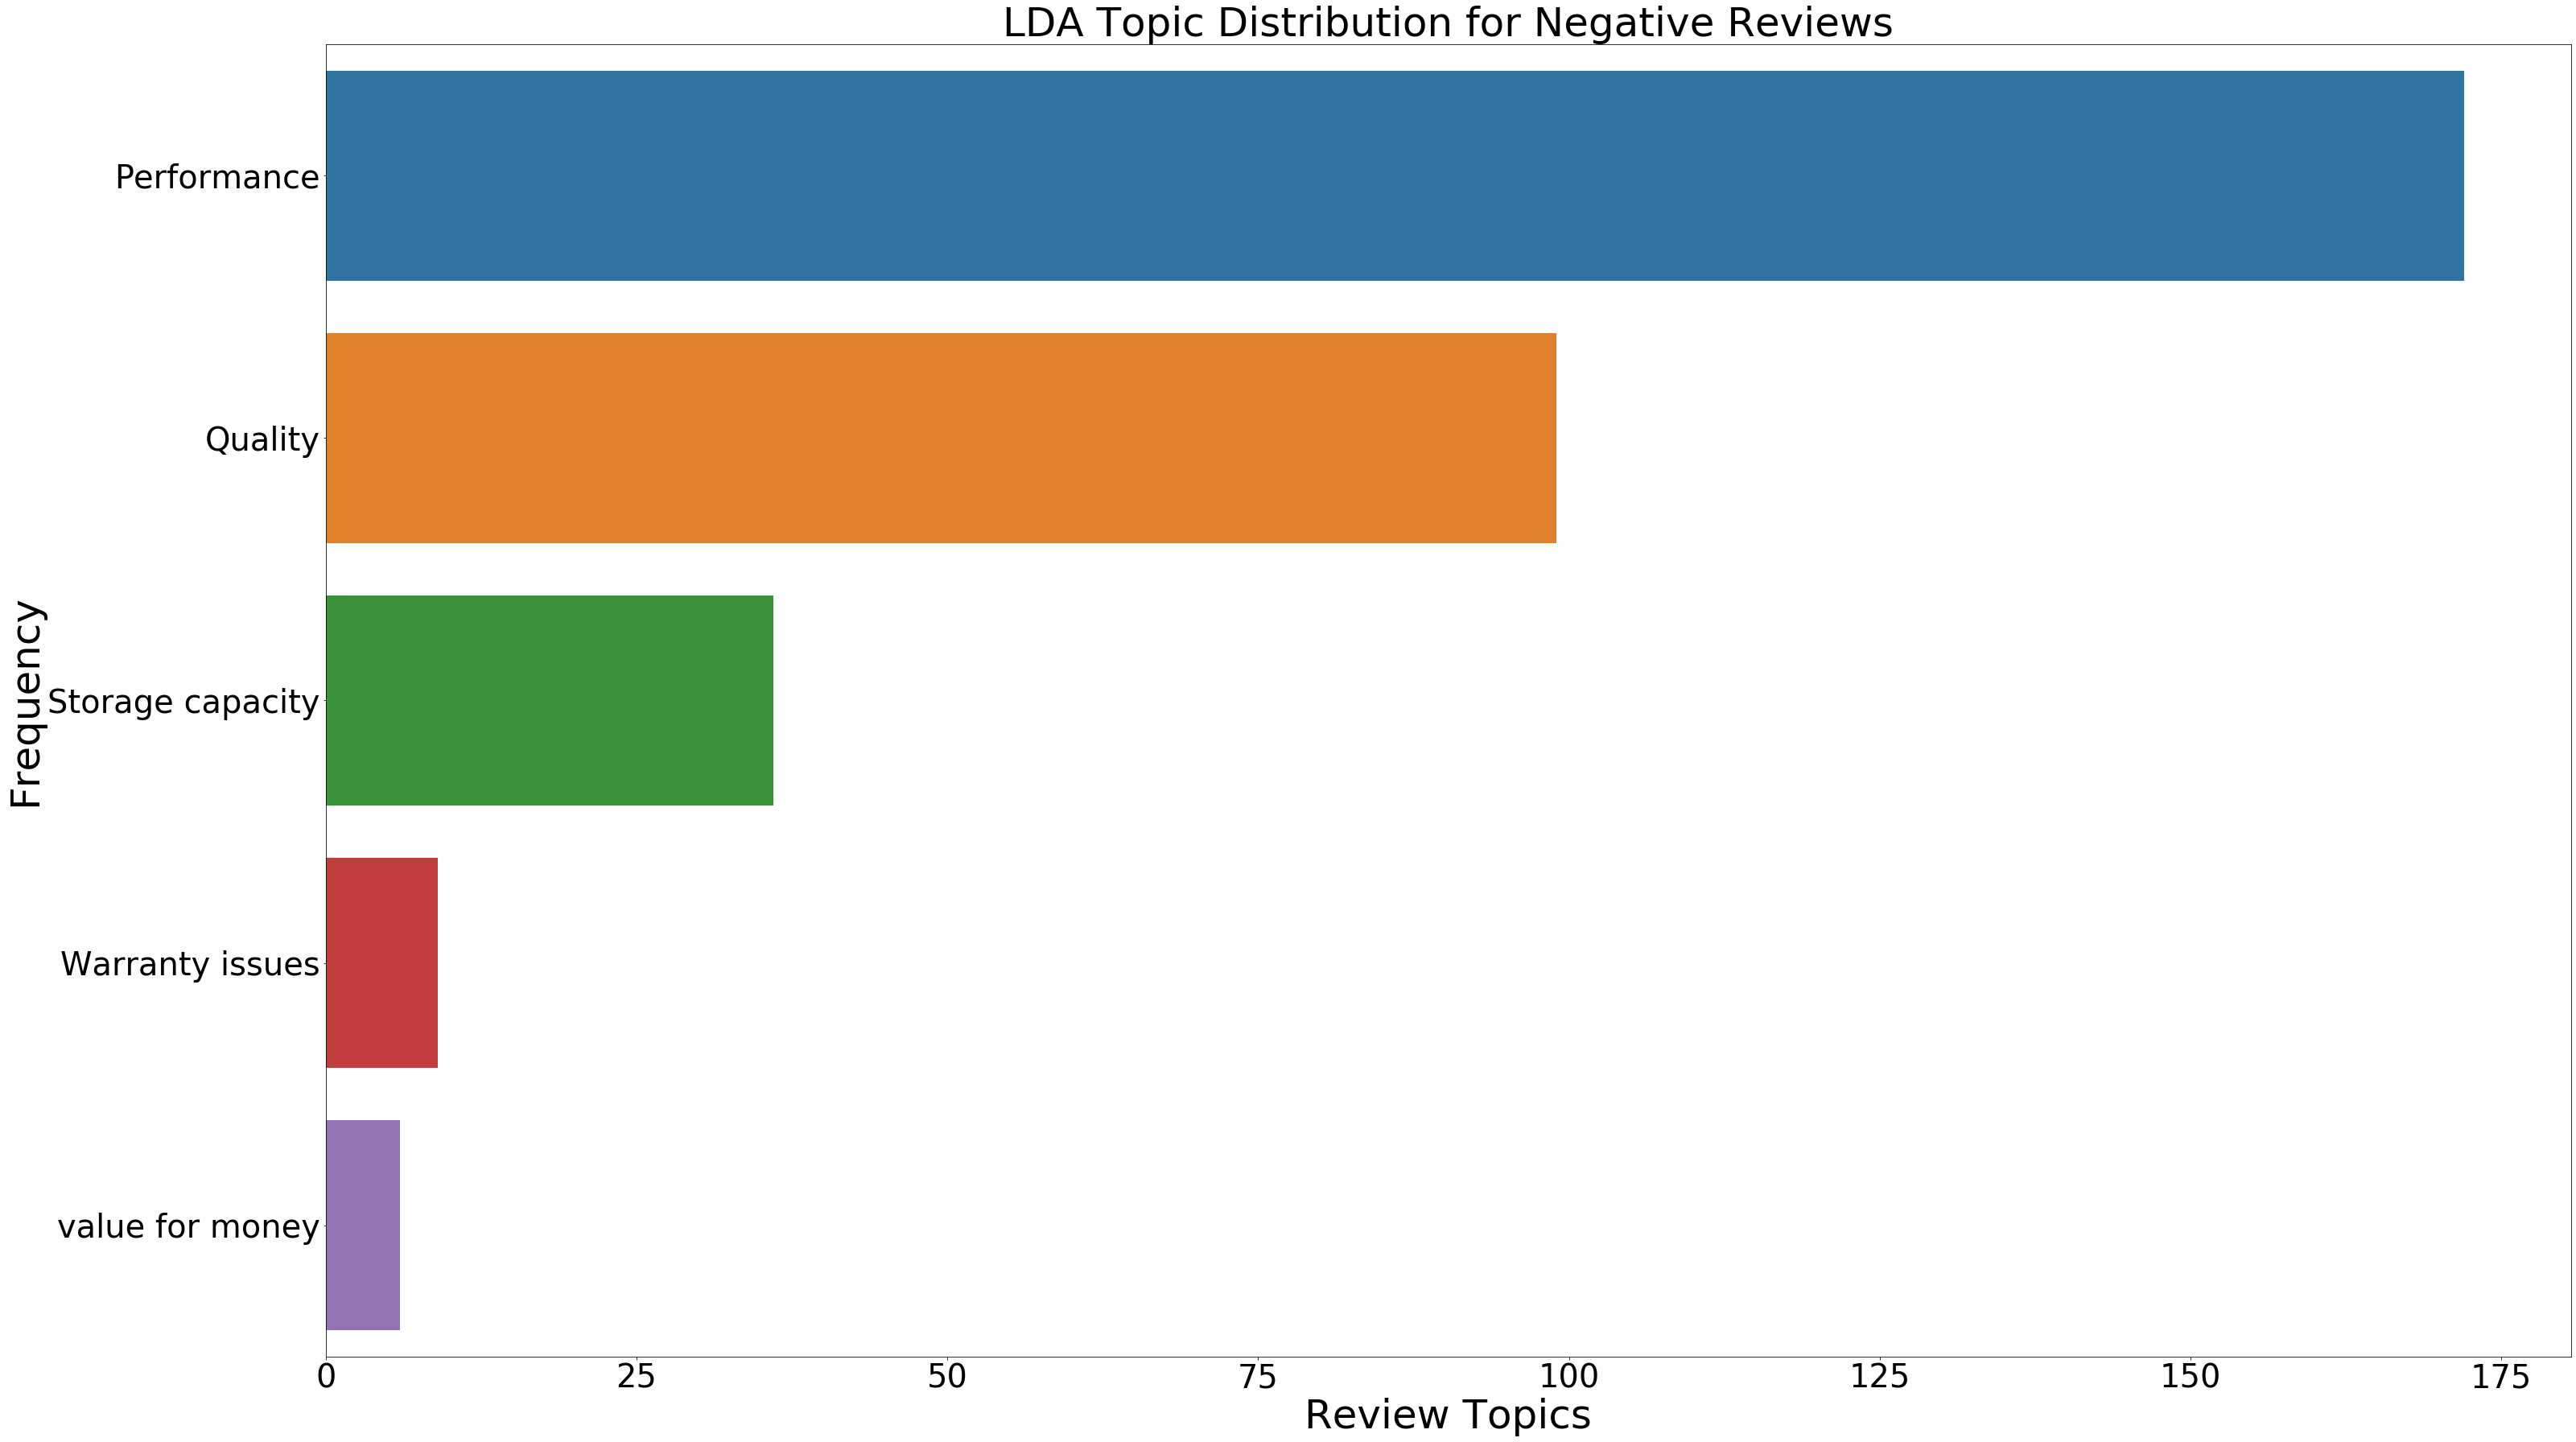

In [58]:
df_neg_ratings = data.loc[(data['sentiment']=='neg')]
lda_neg_x = df_neg_ratings['lda_topics'].value_counts()
lda_neg_y = lda_neg_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(lda_neg_x, lda_neg_y.index)
plt.title("LDA Topic Distribution for Negative Reviews", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)